In [1]:
from astropy.io import fits
from astropy import constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.special import voigt_profile
from lmfit import Model

Load in the spectrum

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/FUV/'

In [3]:
spec = fits.open(rootdir + 'PG1522+101_FUV_wavecal_new.fits')
nodes = fits.open(rootdir + 'PG1522+101_FUV_wavecal_new_nodes.fits')
ids = fits.open(rootdir + 'PG1522+101_FUV_wavecal_new_identifications.fits')

In [4]:
spec_arr = pd.DataFrame(spec[1].data).to_numpy()

wav = spec_arr[:,0]
flux = spec_arr[:,1]
err = spec_arr[:,2]

(-1e-16, 9e-15)

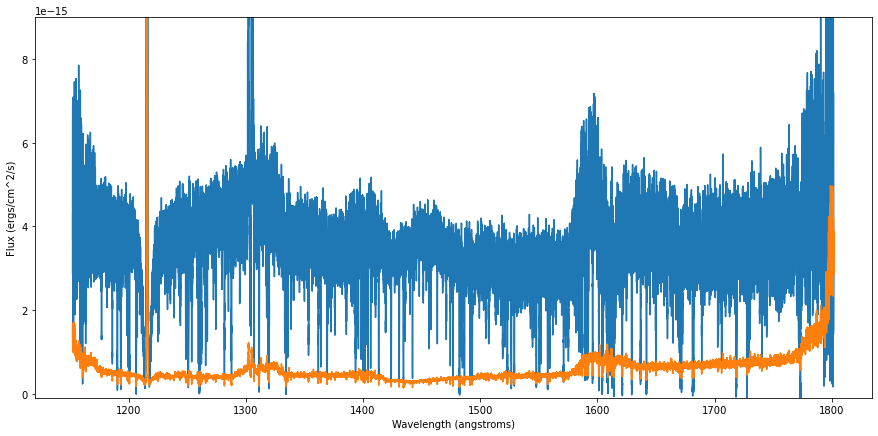

In [5]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav, flux)
ax.plot(wav, err)

ax.set_xlabel('Wavelength (angstroms)')
ax.set_ylabel('Flux (ergs/cm^2/s)')

ax.set_ylim(-1e-16, 9e-15)

Now continuum-normalize the spectrum and its error. First, load in the continuum nodes

In [6]:
cont_arr = pd.DataFrame(nodes[1].data).to_numpy()

cont_wav = cont_arr[:,0]
cont_flux = cont_arr[:,1]

Delete any continuum values that are exactly zero

In [7]:
cont_idx = cont_flux!=0

cont_wav = cont_wav[cont_idx]
cont_flux = cont_flux[cont_idx]

Interpolate the continuum across nodes to sample it at the detector wavelengths

In [8]:
cont_flux_interp = np.interp(wav, cont_wav, cont_flux)

Continuum normalize the flux and error

In [9]:
flux_norm = flux/cont_flux_interp
err_norm = err/cont_flux_interp

(-0.1, 3.0)

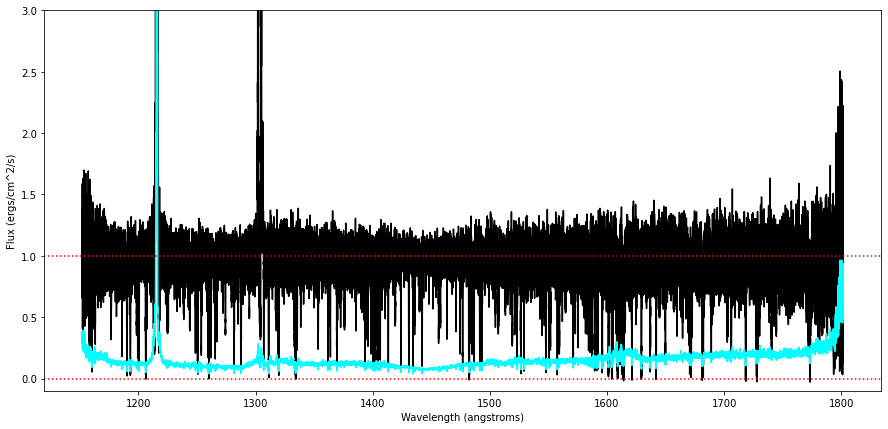

In [10]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav, flux_norm, color='black')
ax.plot(wav, err_norm, color='cyan')
ax.axhline(0, color='red', linestyle=':')
ax.axhline(1, color='red', linestyle=':')


ax.set_xlabel('Wavelength (angstroms)')
ax.set_ylabel('Flux (ergs/cm^2/s)')

ax.set_ylim(-0.1,3)

Grab line identifications

In [11]:
ids_arr = pd.DataFrame(ids[1].data).to_numpy()

In [12]:
ids_arr

array([['NV', True, 1, ..., 0.077, 0, 0],
       ['NV', True, 1, ..., 0.15700000524520874, 0, 1],
       ['SiIV', True, 1, ..., 0.527999997138977, 0, 0],
       ...,
       ['NeVIII', True, 121, ..., 0.05050000175833702, 0, 0],
       ['NeVIII', True, 121, ..., 0.103, 0, 0],
       ['NeIV', True, 121, ..., 0.17, 0, 1]], dtype=object)

In [13]:
ids_arr[0]

array(['NV', True, 1, 1242.804, -0.0002005381646161819, 0.0,
       1242.5547703668624, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0, 0.077, 0, 0], dtype=object)

Given an ID, retrieve the data

In [14]:
idx = 100

In [15]:
ion_ids_data = ids_arr[idx]

In [16]:
ion_name = ion_ids_data[0]
ion_wav0_rest = ion_ids_data[3]
ion_z = ion_ids_data[4]
ion_wav0_obs = ion_ids_data[6]

Let us load in the oscillator strength and damping width table

In [17]:
ions_table = np.loadtxt('/Users/thepoetoftwilight/Documents/CUBS/pabs0/data/linelists/atom.dat', dtype=str)

In [18]:
ions_table

array([['HI', '1215.6701', '0.416400', '6.265E8'],
       ['HI', '1025.7223', '0.079120', '1.897E8'],
       ['HI', '972.5368', '0.029000', '8.127E7'],
       ...,
       ['W5R5', '921.219603', '2.469e-03', '1.031e+09'],
       ['W5R6', '924.496466', '4.262e-03', '1.060e+09'],
       ['W5R7', '928.320649', '5.473e-03', '1.047e+09']], dtype='<U12')

In [19]:
ion_table_idx = np.argmin(np.abs(np.float_(ions_table[:,1])-ion_wav0_rest))

In [20]:
ion_f = float(ions_table[ion_table_idx][2])
ion_gamma = float(ions_table[ion_table_idx][3])

Load in the relevant LSFs

In [21]:
lsf_fits = fits.open(rootdir + 'PG1522_COS_FUV_wavcal2022_lsf_ZQ.fits')

In [22]:
lsf_dat = np.array(lsf_fits[1].data)

For each wavelength, isolate the LSF

In [23]:
lsf_wavs = []

for i in range(len(lsf_dat)):
    lsf_wavs.append(lsf_dat[i][0])
    
lsf_wavs = np.array(lsf_wavs)

Compute line-of-sight velocities for the line

In [24]:
c = 3e+5 #km/s

In [25]:
ion_v = c*(wav-ion_wav0_obs)/ion_wav0_obs
slice_idx = (ion_v>-200)&(ion_v<200)

Find the LSF for the sampled wavelength which is closest to the redshifted wavelength of the line

In [26]:
ion_lsf_idx = np.argmin(np.abs(ion_wav0_obs-lsf_wavs))
ion_lsf = lsf_dat[ion_lsf_idx][2]

In [27]:
ion_delta_v = np.mean(ion_v[1:]-ion_v[:-1])
ion_lsf_central_idx = np.argmax(ion_lsf)
ion_lsf_pix_rel = np.arange(0, len(ion_lsf))-ion_lsf_central_idx
ion_lsf_pix_v = ion_delta_v*ion_lsf_pix_rel

Text(0, 0.5, 'LSF')

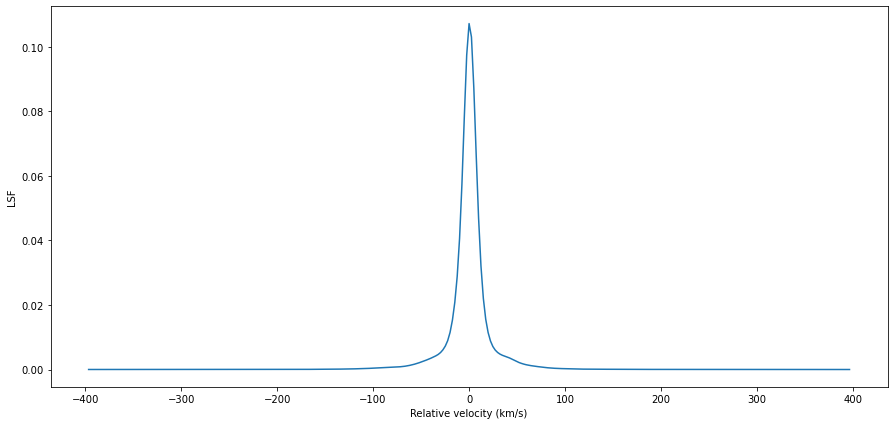

In [28]:
fig, ax = plt.subplots(1, figsize=(15, 7))

ax.plot(ion_lsf_pix_v, ion_lsf)

ax.set_xlabel('Relative velocity (km/s)')
ax.set_ylabel('LSF')

In [29]:
ion_v_obs = ion_v[slice_idx]
ion_flux_obs = flux_norm[slice_idx]
ion_err_obs = err_norm[slice_idx]

In [30]:
ion_v_blue_bound = -90
ion_v_red_bound = 110

In [31]:
def straight_line(x, m, b):
    return m*x+b

In [32]:
def cont_renorm(v_obs, flux_obs, err_obs, v_blue_bound, v_red_bound):
        
    mask = ((v_obs<v_blue_bound)|(v_obs>v_red_bound))
    v_obs_mask = v_obs[mask]
    flux_obs_mask = flux_obs[mask]
    err_obs_mask = err_obs[mask]
        
    cont_model = Model(straight_line)
    
    result = cont_model.fit(flux_obs_mask, 
                            x=v_obs_mask, m=0, b=1,
                            weights=1/err_obs_mask)
    
    return result

In [33]:
result_cont = cont_renorm(ion_v_obs, ion_flux_obs, ion_err_obs, ion_v_blue_bound, ion_v_red_bound)

In [34]:
result_cont

In [35]:
cont_m, cont_b = result_cont.best_values.values()

Regenerate the continuum and re-normalize the flux

In [36]:
cont_new = cont_m*ion_v_obs + cont_b

In [37]:
ion_flux_obs_renorm = ion_flux_obs/cont_new
ion_err_obs_renorm = ion_err_obs/cont_new

Text(0, 0.5, 'Continuum normalized flux')

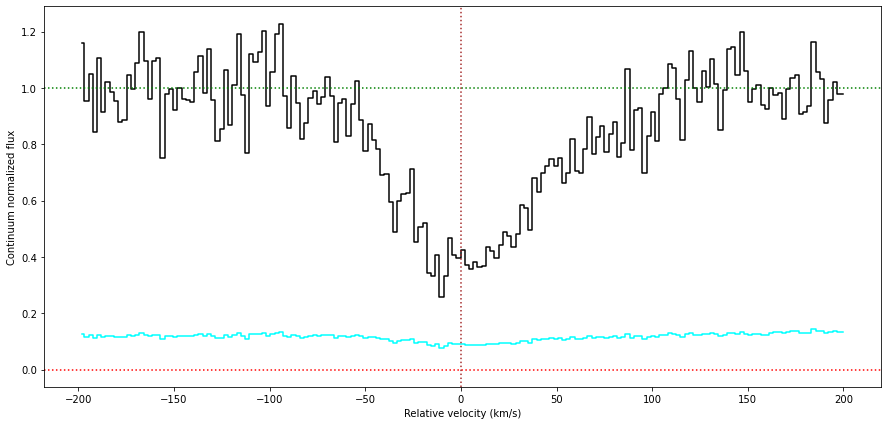

In [38]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(ion_v_obs, ion_flux_obs_renorm, color='black', where='mid')
ax.step(ion_v_obs, ion_err_obs_renorm, color='cyan', where='mid')

ax.axhline(0, color='red', linestyle=':')
ax.axhline(1, color='green', linestyle=':')
ax.axvline(0, color='brown', linestyle=':')

#ax.errorbar(ion_v_obs, ion_flux_obs, yerr = ion_err_obs, color='black', linestyle='', lw=1)

ax.set_xlabel('Relative velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

Define some helper functions

In [39]:
def resample(x, eps=50, N=100):
    
    # For resampling x to a higher frequency
    # Some padding on either end to account for convolution effects later
    
    dx = np.mean(x[1:]-x[:-1])
    x_resample = np.linspace(x[0]-eps*dx, x[-1]+eps*dx, N*len(x))
    return x_resample

In [40]:
def gen_f_v_norm_mod(v_mod, log_N, sigma_v, wav0_obs, f, gamma):
    
    # Get column density
    N = 10**log_N
    
    # Convert wavelength to relative frequency
    c = 3e+5
    nu_0 = 1e+13*c/wav0_obs
    delta_nu = nu_0*v_mod/c
    
    # Convert velocity dispersion to frequency dispersion
    sigma_nu = 1e+13*sigma_v/wav0_obs
    
    # Classical electron cross-section
    sigma_0 = 2.654E-2
    
    # Plug in everything into a Voigt profile
    tau_nu = N*sigma_0*f*voigt_profile(delta_nu, sigma_nu, gamma/(4*np.pi))
    
    return np.exp(-tau_nu)

In [41]:
def model_spec_gen(v_obs, log_N, sigma_v, delta_v_c, **kwargs):
        
    # Load in additional arguments
    wav0_obs = kwargs['wav0_obs']
    f = kwargs['f']
    gamma = kwargs['gamma']
    lsf_convolve = kwargs['lsf_convolve']
    
    if(lsf_convolve == True):
        lsf = kwargs['lsf']
        
    # Resample the wavelengths with some padding
    v_mod = resample(v_obs-delta_v_c)
    
    # Generate model spectrum
    f_v_norm_mod = gen_f_v_norm_mod(v_mod, log_N, sigma_v, wav0_obs, f, gamma)
        
    # Rebin model spectrum
    f_v_norm_rebin = np.interp(v_obs-delta_v_c, v_mod, f_v_norm_mod)
    
    # Convolve it with the LSF after computing wavelength pixel
    if(lsf_convolve == True):
        delta_v_obs = np.mean(v_obs[1:]-v_obs[:-1])
        lsf_central_idx = np.argmax(lsf)
        lsf_pix_rel = np.arange(0, len(lsf))-lsf_central_idx
        lsf_pix_v = delta_v_obs*lsf_pix_rel
        f_v_mod_conv = 1-np.convolve(lsf, 1-f_v_norm_rebin, mode='same')
        
        # Interpolate solution to observed wavelengths
        f_v_mod_interp = np.interp(v_obs-delta_v_c, lsf_pix_v, f_v_mod_conv)

    else:
        f_v_mod_interp = f_v_norm_rebin
    
    return f_v_mod_interp

Let us try to test if LSF convolution works

In [42]:
sigma_v_range = np.array([1, 15, 50])
fwhm_v_range = 2*np.sqrt(2*np.log(2))*sigma_v_range
colors_arr = ['black', 'red', 'green']

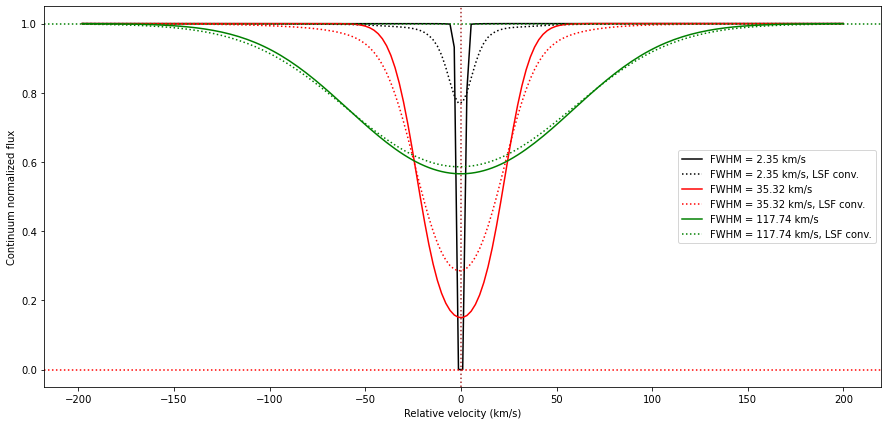

In [43]:
fig, ax = plt.subplots(1, figsize=(15,7))

for i in range(len(sigma_v_range)):
    sigma_v = sigma_v_range[i]
    fwhm_v = fwhm_v_range[i]

    model = model_spec_gen(ion_v_obs, log_N=14.4, sigma_v=sigma_v, delta_v_c=0,
                           wav0_obs = ion_wav0_obs, f = ion_f, 
                           gamma = ion_gamma, lsf_convolve = False)
    model_conv = model_spec_gen(ion_v_obs, log_N=14.4, sigma_v=sigma_v, delta_v_c=0,
                                wav0_obs = ion_wav0_obs, f = ion_f, 
                                gamma = ion_gamma, lsf_convolve = True, lsf = ion_lsf)

    ax.plot(ion_v_obs, model, color=colors_arr[i], label='FWHM = ' + str(np.round(fwhm_v,2))+ ' km/s')
    ax.plot(ion_v_obs, model_conv, color=colors_arr[i], linestyle=':', 
            label='FWHM = ' + str(np.round(fwhm_v,2))+ ' km/s, LSF conv.')

ax.axhline(0, color='red', linestyle=':')
ax.axhline(1, color='green', linestyle=':')
ax.axvline(0, color='brown', linestyle=':')

#ax.errorbar(ion_v_obs, ion_flux_obs, yerr = ion_err_obs, color='black', linestyle='', lw=1)

ax.set_xlabel('Relative velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

ax.legend()

Let's try fitting now

In [44]:
guess = model_spec_gen(ion_v_obs, log_N=14.43, sigma_v=34, delta_v_c=5,
                       wav0_obs = ion_wav0_obs, f = ion_f, 
                       gamma = ion_gamma, lsf_convolve = True, lsf = ion_lsf)

In [45]:
voigt_model = Model(model_spec_gen)
result = voigt_model.fit(ion_flux_obs_renorm, 
                         v_obs=ion_v_obs, log_N=14.43, sigma_v=34, delta_v_c=5,
                         weights=1/ion_err_obs_renorm,
                         wav0_obs = ion_wav0_obs, f = ion_f, gamma = ion_gamma, lsf_convolve = True,
                         lsf = ion_lsf)

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/lmfit/model.py:990: UserWarning: The keyword argument wav0_obs does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/lmfit/model.py:990: UserWarning: The keyword argument f does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/lmfit/model.py:990: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.8/site-packages/lmfit/model.py:990: UserWarning: The keyword argument lsf_convolve does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The

In [46]:
log_N, sigma_v, delta_v_c = result.best_values.values()

In [47]:
log_N_err, sigma_v_err, delta_v_c_err = np.sqrt(result.covar[0,0]), np.sqrt(result.covar[1,1]), np.sqrt(result.covar[2,2])

In [48]:
fit = model_spec_gen(ion_v_obs, log_N, sigma_v, delta_v_c,
                        wav0_obs = ion_wav0_obs, f = ion_f, 
                        gamma = ion_gamma, lsf_convolve = True, lsf = ion_lsf)

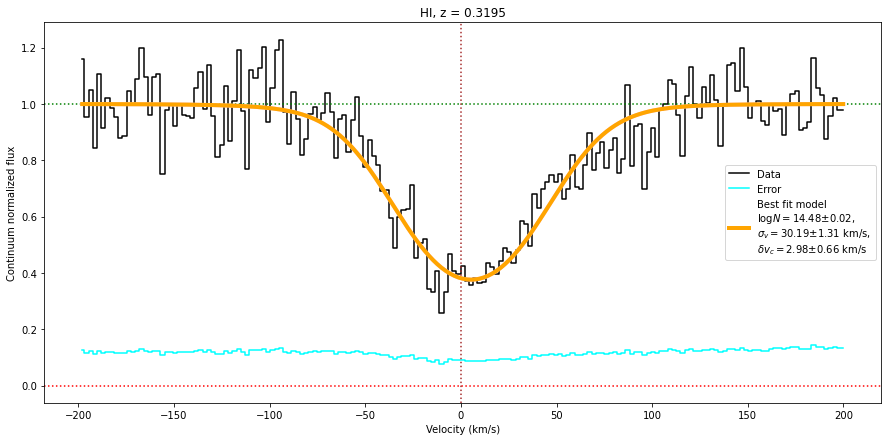

In [49]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(ion_v_obs, ion_flux_obs_renorm, color='black', where='mid', label='Data')
ax.step(ion_v_obs, ion_err_obs_renorm, color='cyan', where='mid', label='Error')
ax.axhline(0, color='red', linestyle=':')
ax.axhline(1, color='green', linestyle=':')
ax.axvline(0, color='brown', linestyle=':')
ax.plot(ion_v_obs, fit, lw='4', color='pink')
ax.plot(ion_v_obs, result.best_fit, 
        label='Best fit model' +  '\n'
        r'$\logN = $' + str(np.round(log_N, 2)) + r'$\pm$' + str(np.round(log_N_err, 2)) + ', \n' +
        r'$\sigma_v = $' + str(np.round(sigma_v, 2)) +  r'$\pm$' + str(np.round(sigma_v_err, 2)) + ' km/s' + ', \n' +
        r'$\delta v_c = $' + str(np.round(delta_v_c, 2)) +  r'$\pm$' + str(np.round(delta_v_c_err, 2)) + ' km/s',
        lw=4, color='orange')

ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Continuum normalized flux')

ax.set_title(ion_ids_data[0] + ', z = ' + str(round(ion_ids_data[4], 4)))
ax.legend()